In [1]:
import gym
from collections import defaultdict
import numpy as np
import bottleneck as bn
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [6]:
class QTable:
    def __init__(self, learning_rate, discount_factor, epsilon, start_eps_decay, end_eps_decay, eps_decay, default_q, n_actions, q_table=None):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.n_actions = n_actions
        self.epsilon = epsilon
        
        self.start_eps_decay = start_eps_decay
        self.end_eps_decay = end_eps_decay
        self.eps_decay = eps_decay
        
        self.episode = 0
        
        self.hist = []
        self.init_q_table(q_table)
        
    def init_q_table(self, q_table):
        if q_table is None:
            self.q_table = defaultdict(lambda: [np.random.uniform(-2, 0) for _ in range(self.n_actions)])
        else:
            self.q_table = q_table
    
    def cal_update(self, old_value, reward, max_future_value):
        temporal_difference_target = reward + self.discount_factor * max_future_value
        temporal_difference = temporal_difference_target - old_value
        learnd_value = old_value + self.learning_rate * temporal_difference
        return learnd_value
    
    def update(self, current_state_key, future_state_key, reward, action, terminate_state):
        if not terminate_state:
            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(self.q_table[future_state_key])

            # Current Q value (for current state and performed action)
            current_q = self.q_table[current_state_key][action]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount_factor * max_future_q)

            # Update Q table with new Q value
            self.q_table[current_state_key][action] = new_q

        else:
            self.q_table[current_state_key][action] = 0
            self.__decay_epsilon()
            self.episode += 1
        
    def act(self, state_key):
        q_values = self.q_table[state_key]
        
        if np.random.random() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(0, self.n_actions)
            
        return action
    
    def __decay_epsilon(self):
        if self.start_eps_decay <= self.episode <=  self.end_eps_decay:
            self.epsilon -= self.eps_decay
            
        
        

In [7]:
lr = 0.1
dis = 0.95
epochs = 25000
show_period = 3000
start_period = 1000
epsilon = 1.0
start_eps_decay = 1
end_eps_decay = epochs//4 * 3
eps_decay = epsilon/(end_eps_decay-start_eps_decay)
default_q = 0

env = gym.make("MountainCar-v0")

action_numbers = env.action_space.n
state_dis_number = np.full(env.observation_space.shape, 20)
obs_lows = env.observation_space.low
obs_high = env.observation_space.high

def min_max_normalization(x, min_, max_):
    return (x - min_) / (max_ - min_)

def gen_state(state):
    norm_state = min_max_normalization(state, obs_lows, obs_high)
    dis_state = np.round(norm_state * state_dis_number).astype(np.int)
    state_key = ",".join(dis_state.astype(str))
    
    return state_key

agent = QTable(learning_rate=lr, discount_factor=dis, epsilon=epsilon, 
               start_eps_decay=start_eps_decay, end_eps_decay=end_eps_decay, eps_decay=eps_decay, 
               default_q=default_q, n_actions=action_numbers)

ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': [], "eps":[]}

states = []

for epoch in range(epochs):
    observation = env.reset()
    state_key = gen_state(observation)
    old_observation = observation
    
    done = False
    
    epoch_reward = 0
    while not done:
        action = agent.act(state_key)
        observation, reward, done, info = env.step(action)
        furure_state_key = gen_state(observation)
        
        if observation[0] >= env.goal_position:
            reward = 0
        
        agent.update(state_key, furure_state_key, reward, action, done)
        states.append([state_key, furure_state_key, reward, action, done, observation, old_observation])
        state_key = furure_state_key
        old_observation = observation
        epoch_reward+=reward
        
        if not epoch%show_period:
            env.render()
    
    ep_rewards.append(epoch_reward)
    if not epoch % start_period:
        average_reward = sum(ep_rewards[-start_period:])/start_period
        aggr_ep_rewards['ep'].append(epoch)
        aggr_ep_rewards['eps'].append(agent.epsilon)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-start_period:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-start_period:]))
        print(f'Episode: {epoch:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {agent.epsilon:>1.2f}')
    
env.close()

Episode:     0, average reward: -0.2, current epsilon: 1.00
Episode:  1000, average reward: -200.0, current epsilon: 0.95
Episode:  2000, average reward: -200.0, current epsilon: 0.89
Episode:  3000, average reward: -200.0, current epsilon: 0.84
Episode:  4000, average reward: -200.0, current epsilon: 0.79
Episode:  5000, average reward: -200.0, current epsilon: 0.73
Episode:  6000, average reward: -200.0, current epsilon: 0.68
Episode:  7000, average reward: -200.0, current epsilon: 0.63
Episode:  8000, average reward: -200.0, current epsilon: 0.57
Episode:  9000, average reward: -200.0, current epsilon: 0.52
Episode: 10000, average reward: -200.0, current epsilon: 0.47
Episode: 11000, average reward: -200.0, current epsilon: 0.41
Episode: 12000, average reward: -200.0, current epsilon: 0.36
Episode: 13000, average reward: -200.0, current epsilon: 0.31


KeyboardInterrupt: 

In [40]:
# [old_values, 
#old_value, 
#new_q_values, 
#self.q_tabel[current_state_key], 
# learnd_value, future_values, max_future_value, 
# current_state_key, future_state_key, reward, action, terminate_state]

In [44]:
old_values = [-0.16679683556488373, -1.5536235001987322, -1.1624984490941037]
furtur_values = [-12.573128360188386, -12.82739084765884, -12.841998398554466]
reward = -1.0
action = 2

In [46]:
new_q = old_values[action] + lr * (reward + dis * np.max(furtur_values) - old_values[action])

In [47]:
new_q

-2.34069579840259

In [12]:
random.choices(agent.hist)

[[[-3.851434285149324, -3.006126231640572, -4.235182707588258],
  -3.006126231640572,
  [-3.851434285149324, -3.0910956004823693, -4.235182707588258],
  [-3.851434285149324, -3.0910956004823693, -4.235182707588258],
  -3.0910956004823693,
  [-3.851434285149324, -3.006126231640572, -4.235182707588258],
  -3.006126231640572,
  '6,10',
  '6,10',
  -1.0,
  1,
  False]]

In [13]:
random.choices(states)

[['9,8',
  '9,8',
  -1.0,
  0,
  False,
  array([-0.36174633, -0.01333583]),
  array([-0.3484105 , -0.01108157])]]

In [49]:
new_action_qs = old_values
new_action_qs[action] = new_q

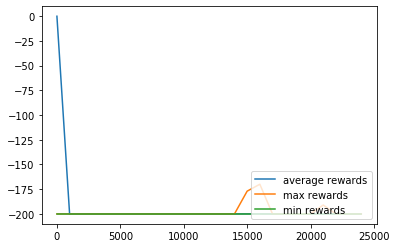

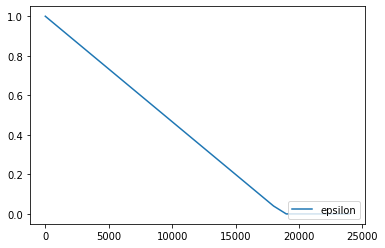

In [9]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()

plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['eps'], label="epsilon")
plt.legend(loc=4)
plt.show()

In [14]:
env.close()

In [ ]:
agent.q_table

In [34]:
env.close()

In [17]:
q_table_save = agent.q_table.copy()

In [20]:
q_table[0]

array([[ -0.40273339,  -1.45018966,  -1.74370722],
       [ -1.33127795,  -1.29668713,  -1.7805012 ],
       [ -1.46816121,  -1.59922594,  -0.27674495],
       [ -7.79523959,  -7.48251917,  -8.41090096],
       [-13.60187352, -13.63800711, -13.60970914],
       [-14.08275193, -14.16152965, -14.07109794],
       [-14.37601709, -14.59615471, -14.54761468],
       [-14.46209958, -14.64565814, -14.66465004],
       [-14.57370265, -14.3992035 , -14.35420018],
       [-14.28945065, -14.13121454, -13.75514367],
       [-13.38135052, -13.32437914, -13.21673111],
       [-12.54831647, -12.49321792, -12.52558455],
       [-11.89256313, -12.03761798, -11.8861876 ],
       [-10.00561922,  -9.61682422,  -9.69301064],
       [ -0.37022456,  -1.53670722,  -1.84607239],
       [ -1.16404863,  -0.92855513,  -0.44366157],
       [ -0.46749058,  -1.56446286,  -1.10028517],
       [ -0.56603822,  -0.56605193,  -1.63759311],
       [ -1.79325344,  -0.93794518,  -1.67646484],
       [ -0.29913288,  -0.52046

0
Episode:     0, average reward: -0.2, current epsilon: 1.00
Episode:  1000, average reward: -200.0, current epsilon: 0.92
Episode:  2000, average reward: -200.0, current epsilon: 0.84
3000
Episode:  3000, average reward: -200.0, current epsilon: 0.76
Episode:  4000, average reward: -200.0, current epsilon: 0.68
Episode:  5000, average reward: -200.0, current epsilon: 0.60
6000
Episode:  6000, average reward: -200.0, current epsilon: 0.52
Episode:  7000, average reward: -199.8, current epsilon: 0.44
Episode:  8000, average reward: -199.0, current epsilon: 0.36
9000
Episode:  9000, average reward: -194.6, current epsilon: 0.28
Episode: 10000, average reward: -187.8, current epsilon: 0.20
Episode: 11000, average reward: -184.7, current epsilon: 0.12
12000
Episode: 12000, average reward: -169.1, current epsilon: 0.04
Episode: 13000, average reward: -167.0, current epsilon: -0.00
Episode: 14000, average reward: -170.8, current epsilon: -0.00
15000
Episode: 15000, average reward: -158.6, c

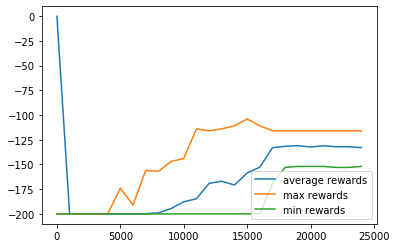

In [2]:
# objective is to get the cart to the flag.
# for now, let's just move randomly:

import gym
import numpy as np

env = gym.make("MountainCar-v0")

LEARNING_RATE = 0.1

DISCOUNT = 0.95
EPISODES = 25000
SHOW_EVERY = 3000
STATS_EVERY = 1000
DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)


q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))


# For stats
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the 3 Q values for the available actions in the q-table


for episode in range(EPISODES):
    episode_reward = 0
    discrete_state = get_discrete_state(env.reset())
    done = False

    if episode % SHOW_EVERY == 0:
        render = True
        print(episode)
    else:
        render = False

    while not done:

        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)


        new_state, reward, done, _ = env.step(action)
        episode_reward += reward
        new_discrete_state = get_discrete_state(new_state)

        if episode % SHOW_EVERY == 0:
            env.render()
        #new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

        # If simulation did not end yet after last step - update Q table
        if not done:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state + (action,)]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            # Update Q table with new Q value
            q_table[discrete_state + (action,)] = new_q


        # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
        elif new_state[0] >= env.goal_position:
            #q_table[discrete_state + (action,)] = reward
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    ep_rewards.append(episode_reward)
    if not episode % STATS_EVERY:
        average_reward = sum(ep_rewards[-STATS_EVERY:])/STATS_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')

env.close()

plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()

In [9]:
action_numbers = env.action_space.n
state_dis_number = np.full(env.observation_space.shape, 20)
obs_lows = env.observation_space.low
obs_high = env.observation_space.high

def min_max_normalization(x, min_, max_):
    return (x - min_) / (max_ - min_)

def gen_state(state):
    norm_state = min_max_normalization(state, obs_lows, obs_high)
    dis_state = np.round(norm_state * state_dis_number).astype(np.int)
    state_key = ",".join(dis_state.astype(str))
    
    return state_key

0
Episode:     0, average reward: -0.2, current epsilon: 1.00
Episode:  1000, average reward: -200.0, current epsilon: 0.92
Episode:  2000, average reward: -200.0, current epsilon: 0.84
3000
Episode:  3000, average reward: -200.0, current epsilon: 0.76
Episode:  4000, average reward: -200.0, current epsilon: 0.68
Episode:  5000, average reward: -200.0, current epsilon: 0.60
6000
Episode:  6000, average reward: -200.0, current epsilon: 0.52
Episode:  7000, average reward: -199.6, current epsilon: 0.44
Episode:  8000, average reward: -198.1, current epsilon: 0.36
9000
Episode:  9000, average reward: -196.3, current epsilon: 0.28
Episode: 10000, average reward: -190.5, current epsilon: 0.20
Episode: 11000, average reward: -179.7, current epsilon: 0.12
12000
Episode: 12000, average reward: -165.8, current epsilon: 0.04
Episode: 13000, average reward: -159.2, current epsilon: -0.00
Episode: 14000, average reward: -152.2, current epsilon: -0.00
15000
Episode: 15000, average reward: -140.9, c

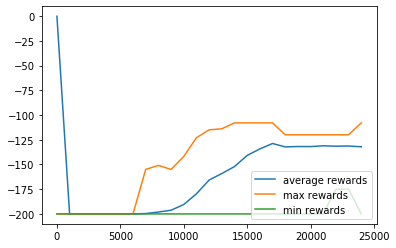

In [10]:
# objective is to get the cart to the flag.
# for now, let's just move randomly:

import gym
import numpy as np

env = gym.make("MountainCar-v0")

LEARNING_RATE = 0.1

DISCOUNT = 0.95
EPISODES = 25000
SHOW_EVERY = 3000
STATS_EVERY = 1000
DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)


q_table = defaultdict(lambda: [np.random.uniform(-2, 0) for _ in range(env.action_space.n)]) #np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))


# For stats
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the 3 Q values for the available actions in the q-table


for episode in range(EPISODES):
    episode_reward = 0
    discrete_state = gen_state(env.reset())
    done = False

    if episode % SHOW_EVERY == 0:
        render = True
        print(episode)
    else:
        render = False

    while not done:

        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)


        new_state, reward, done, _ = env.step(action)
        episode_reward += reward
        new_discrete_state = gen_state(new_state)

        if episode % SHOW_EVERY == 0:
            env.render()
        #new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

        # If simulation did not end yet after last step - update Q table
        if not done:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state][action]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            # Update Q table with new Q value
            q_table[discrete_state][action] = new_q


        # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
        elif new_state[0] >= env.goal_position:
            #q_table[discrete_state + (action,)] = reward
            q_table[discrete_state][action] = 0

        discrete_state = new_discrete_state

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    ep_rewards.append(episode_reward)
    if not episode % STATS_EVERY:
        average_reward = sum(ep_rewards[-STATS_EVERY:])/STATS_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')

env.close()

plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()

0
Episode:     0, average reward: -0.2, current epsilon: 1.00
Episode:  1000, average reward: -200.0, current epsilon: 0.92
Episode:  2000, average reward: -200.0, current epsilon: 0.84
3000
Episode:  3000, average reward: -200.0, current epsilon: 0.76
Episode:  4000, average reward: -200.0, current epsilon: 0.68
Episode:  5000, average reward: -200.0, current epsilon: 0.60
6000
Episode:  6000, average reward: -200.0, current epsilon: 0.52
Episode:  7000, average reward: -200.0, current epsilon: 0.44
Episode:  8000, average reward: -200.0, current epsilon: 0.36
9000
Episode:  9000, average reward: -199.9, current epsilon: 0.28
Episode: 10000, average reward: -199.7, current epsilon: 0.20
Episode: 11000, average reward: -199.3, current epsilon: 0.12
12000
Episode: 12000, average reward: -198.9, current epsilon: 0.04
Episode: 13000, average reward: -199.7, current epsilon: -0.00
Episode: 14000, average reward: -200.0, current epsilon: -0.00
15000
Episode: 15000, average reward: -200.0, c

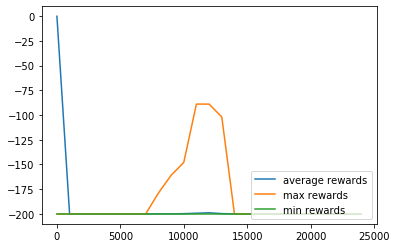

In [8]:
# objective is to get the cart to the flag.
# for now, let's just move randomly:

import gym
import numpy as np

env = gym.make("MountainCar-v0")

LEARNING_RATE = 0.1

DISCOUNT = 0.95
EPISODES = 25000
SHOW_EVERY = 3000
STATS_EVERY = 1000
DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)


#q_table = defaultdict(lambda: [np.random.uniform(-2, 0) for _ in range(env.action_space.n)]) #np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))
agent2 = QTable(LEARNING_RATE, DISCOUNT, epsilon, START_EPSILON_DECAYING, END_EPSILON_DECAYING, epsilon_decay_value, 0, 3)

# For stats
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the 3 Q values for the available actions in the q-table


for episode in range(EPISODES):
    episode_reward = 0
    discrete_state = gen_state(env.reset())
    done = False

    if episode % SHOW_EVERY == 0:
        render = True
        print(episode)
    else:
        render = False

    while not done:

        action = agent2.act(discrete_state)
        
        #if np.random.random() > epsilon:
        #    # Get action from Q table
        #    action = np.argmax(q_table[discrete_state])
        #else:
        #    # Get random action
        #    action = np.random.randint(0, env.action_space.n)


        new_state, reward, done, _ = env.step(action)
        episode_reward += reward
        new_discrete_state = gen_state(new_state)

        if episode % SHOW_EVERY == 0:
            env.render()
        #new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        
        agent2.update(discrete_state, new_discrete_state, reward, action, done)
        
        # If simulation did not end yet after last step - update Q table
        #if not done:

            # Maximum possible Q value in next step (for new state)
            #max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            #current_q = q_table[discrete_state][action]

            # And here's our equation for a new Q value for current state and action
            #new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            # Update Q table with new Q value
            #q_table[discrete_state][action] = new_q
            
            

        # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
        #elif new_state[0] >= env.goal_position:
        #    #q_table[discrete_state + (action,)] = reward
        #    q_table[discrete_state][action] = 0

        #discrete_state = new_discrete_state

    # Decaying is being done every episode if episode number is within decaying range
    #if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
    #    epsilon -= epsilon_decay_value

    ep_rewards.append(episode_reward)
    if not episode % STATS_EVERY:
        average_reward = sum(ep_rewards[-STATS_EVERY:])/STATS_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {agent2.epsilon:>1.2f}')

env.close()

plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()